# v调试

In [4]:
from methods.trans_lasso import Trans_lasso
from methods.t_lasso import T_lasso
from methods.least_square import Least_square


from evaluator.evaluator import *
from evaluator.sample_generator import *
from tqdm import tqdm
from matplotlib import pyplot as plt
import time
import numpy as np
from methods.utils import *

In [5]:
from methods.estiminator import estiminator
import numpy as np
from sklearn.linear_model import Lasso
import time

class Our_method(estiminator):
    def __init__(self, n_features=0,s=0,L=0,instance=None):
        if instance is not None:
            super(Our_method, self).__init__(instance.n_features,instance.s,instance.L)
        else:
            assert n_features>0 and s>0 and L>0
            super(Our_method, self).__init__(n_features,s,L)
      
    #这个方法没有用到，目的是方便使用梯度下降等方法，将更新方法放到模型里面去  
    def likelihood(self, beta, delta, samples_pack):
        beta=beta+delta
        X=samples_pack.getX()
        y=samples_pack.getY()
        # 似然函数为高斯分布
        return -np.sum((y-np.dot(X,beta))**2)
    
    #更新beta
    #输入：delta:辅助模型与目标模型的回归系数差矩阵，v:辅助模型是否被选择的向量，samples_packs:样本数据
    # 优化问题：argmax_{beta} l_0(beta)+sum_{k=1}^{K}(l_k(beta,delta[k])-lambda*||delta||_2)*v[k]
    def update_beta(self, delta, v, samples_packs):
        # 对于线性模型，该问题有显式解
        # 该显式解为beta=(x0^T*x0+sum_{k=1}^{K}v[k]*xk^T*xk-lambda*E)^{-1}*(x0^T*y0+sum_{k=1}^{K}v[k]*xk^T*yk-sum_{k=1}^{K}v[k]*xk^T*xk*delta[k])
        # x0,y0为目标模型的样本数据
        # xk,yk为第k个辅助模型的样本数据
        
        #mat1=x0^T*x0+sum_{k=1}^{K}v[k]*xk^T*xk-lambda*E
        lamb=0.001
        mat1=np.dot(samples_packs[0].getX().T,samples_packs[0].getX())
        # mat1-=lamb*np.eye(len(samples_packs[0].getX()[0]))
        for i in range(len(samples_packs)-1):
            if v[i]==1:
                mat1+=np.dot(samples_packs[i+1].getX().T,samples_packs[i+1].getX())
        #mat2=x0^T*y0+sum_{k=1}^{K}v[k]*xk^T*yk
        mat2=np.dot(samples_packs[0].getX().T,samples_packs[0].getY())
        for i in range(len(samples_packs)-1):
            if v[i]==1:
                mat2+=np.dot(samples_packs[i+1].getX().T,samples_packs[i+1].getY())
        #mat3=sum_{k=1}^{K}v[k]*xk^T*xk*delta[k]
        mat3=np.zeros(len(samples_packs[0].getX()[0]))
        for i in range(len(samples_packs)-1):
            if v[i]==1:
                mat3+=np.dot(samples_packs[i+1].getX().T,np.dot(samples_packs[i+1].getX(),delta[i]))
        beta=np.dot(np.linalg.inv(mat1),mat2-mat3)
        return beta
    
    #更新delta
    #输入：beta:当前beta，sample_pack:该模型的样本数据
    #输出：更新后的delta_k
    def update_delta_k(self,beta,sample_pack):  
        # 该优化问题为: argmin_{delta_k} ||y_k-x_k*beta-x_k*delta_k||_2^2+lambda*||delta_k||_2
        # 该问题好像没有显式解，但函数是凸函数，可以使用梯度下降法求解
        # 目标函数在0处不可导
        # -?先比较lambda与||X.T*y||_2的大小，如果lambda大，则delta_k=0
        # -?使用IHT迭代算法求解
        lamb=0.1#-?
        X=sample_pack.getX()
        y=sample_pack.getY()
        y=y-np.dot(X,beta)#优化delta
        if lamb>=np.linalg.norm(np.dot(X.T,y)):
            return np.zeros(len(X[0]))
        else:
            #使用IHT方法迭代求解
            #先测试一下
            #L是X的最大奇异值
            U,sigma,VT=np.linalg.svd(X)
            Lipschitz=sigma[0]*sigma[0]
            # print(Lipschitz)
            max_iter=1000
            #岭回归结果作为初值
            delta=np.dot(np.linalg.inv(np.dot(X.T,X)+lamb*np.eye(len(X[0]))),np.dot(X.T,y))
            delta2=delta+0
            for i in range(max_iter):
                #计算梯度
                grad=np.dot(X.T,np.dot(X,delta)-y)
                b=delta-1/Lipschitz*grad
                # assert 2*lamb/Lipschitz<np.linalg.norm(b)#初始条件保证不可能进这里
                delta=(1-lamb/(Lipschitz*np.linalg.norm(b)))*b
                if np.linalg.norm(delta-delta2)<0.0001:
                    break
                delta2=delta
            return delta
        
    
    # 非iid分布式迁移学习与数据源选择
    # delta[k]=beta[k]-beta[0] 为第k个辅助模型与目标模型的回归系数差
    # 上述参数均为n_features维向量
    # v[k]属于{0,1},为第k个辅助模型是否被选择
    # 优化问题：argmax_{beta,delta[k],v[k]} l_0(beta)+sum_{k=1}^{K}(l_k(beta,delta[k])-lambda*||delta||_2)*v[k]
    # s.t. ||v||_0=L
    # l_k为模型的似然函数，当前模型为线性模型，似然函数为高斯分布
    # 使用两步迭代算法求解
    # 第一步：固定v[k]，求解beta[0],delta[k]
    # 求解beta与delta时也使用两步迭代算法
    # 第二步：固定beta[0],delta[k]，求解v[k]
    # 重复以上两步直到收敛（或达到最大迭代次数）
    # -?没有设置收敛条件，目前仅仅设置了最大迭代次数
    # 输入：samples_packs:样本数据，s:目标模型稀疏度，L:选定的辅助模型个数
    def fit(self, samples_packs,s=0,L=0):
        #如果model_num==0,则直接使用目标模型的样本数据进行lasso估计
        if s==0:
            s=self.s
        if L==0:
            L=self.L
        model_num=len(samples_packs)-1
        if model_num==0:
            lasso=Lasso(alpha=0.01)
            lasso.fit(samples_packs[0].getX(),samples_packs[0].getY())
            #保留绝对值前s大个-?有意义吗？
            self.params=lasso.coef_
            return lasso.coef_,[],[],[]
        # 初始化参数
        # -?第一次迭代时使用全部模型,v=[1,1,1,1,...]
        #计算程序运行时间
        start_time=time.time()
        times=[]
        times.append(time.time()-start_time)
        
        # v=np.ones(len(samples_packs)-1)
        # v1=np.ones(len(samples_packs)-1)
        v=np.zeros(len(samples_packs)-1)
        v1=np.zeros(len(samples_packs)-1)
        # beta为目标模型的回归系数
        beta=np.zeros(len(samples_packs[0].getX()[0]))
        delta=np.zeros((len(samples_packs)-1,len(samples_packs[0].getX()[0])))
        # 迭代求解
        max_iter=1000
        # 设置算法的退出阈值threshold
        threshold=0.0001
        beta1=np.ones(len(samples_packs[0].getX()[0]))
        beta2=np.ones(len(samples_packs[0].getX()[0]))
        for i in range(max_iter):
            # 第一步:交替求解beta与delta
            if i==0:
                times.append(time.time()-start_time)
            for j in range(max_iter):
                beta=self.update_beta(delta,v,samples_packs)
                #计算beta与beta2的差的2范数
                if np.linalg.norm(beta-beta2)<threshold:
                    break
                beta2=beta
                if i==0:
                    times.append(time.time()-start_time)
                #对K个辅助模型分别更新其delta_k
                for k in range(len(samples_packs)-1):
                    delta[k]=self.update_delta_k(beta,samples_packs[k+1])
                if i==0:
                    times.append(time.time()-start_time)
            if np.linalg.norm(beta-beta1)<threshold:
                break
            beta1=beta
            # 第二步：更新v
            # 选择delta的q范数最小的L个模型，将其对应的v设为1，其余设为0。
            # 目前选择q=2
            if i==0:
                times.append(time.time()-start_time)
            v=np.zeros(len(samples_packs[1:]))
            v[np.argsort(np.linalg.norm(delta,axis=1))[:L]]=1
            if np.linalg.norm(v-v1)<threshold:#-?除了beta不变之外，加入了v不变的退出条件。实际上这两个退出的效果是一样的（吗？）
                break
            v1=v
            if i==0:
                times.append(time.time()-start_time)
        # 返回beta
        # -?暂时不设置稀疏度-?设置了一下
        #保留绝对值前s大个
        # beta[np.argsort(np.abs(beta))[:-s]] = 0
        self.params=beta
        return beta,delta,v

In [6]:
n_features=16
n_samples=100
n_packs=101
s=16
L_list=[2,4,8,12,16,20,24,28,32,36,40]
# L_list=[2,4,8,12,16]
h_list=[2]
model_dic={"ours":Our_method(n_features,s,1),"lasso":T_lasso(n_features,s,1),"Least_square":Least_square(n_features,s,1)}

In [12]:
import multiprocessing
workers=multiprocessing.cpu_count()
result_list=[]
for h in h_list:
    result_list.append([])
    for L in tqdm(L_list):
    # for L in tqdm([2,4,8,12]):
        result_list[-1].append([])
        eval=evaluator(repeat_times=1,model_num=len(model_dic))
        for i in range(10):#选一个可以被workers整除的数
            sample_packs,coef_true=t22_eval(n_features,s,n_packs,n_samples,h,L)
            eval.append(model_dic,sample_packs,coef_true,s,L,False)
        eval.run(workers,False)
        result_list[-1][-1]=eval.result_list
#将result_list保存下来
result_list=np.array(result_list)
np.save('log/result_list5'+time.strftime("%m-%d", time.localtime())+'.npy',result_list)

 36%|███▋      | 4/11 [00:59<02:03, 17.58s/it]

In [9]:
result_list.shape

(1, 11, 3, 5)

In [10]:
result=np.mean(result_list,axis=3)
#将第二个轴和第三个轴交换
result=np.swapaxes(result,1,2)

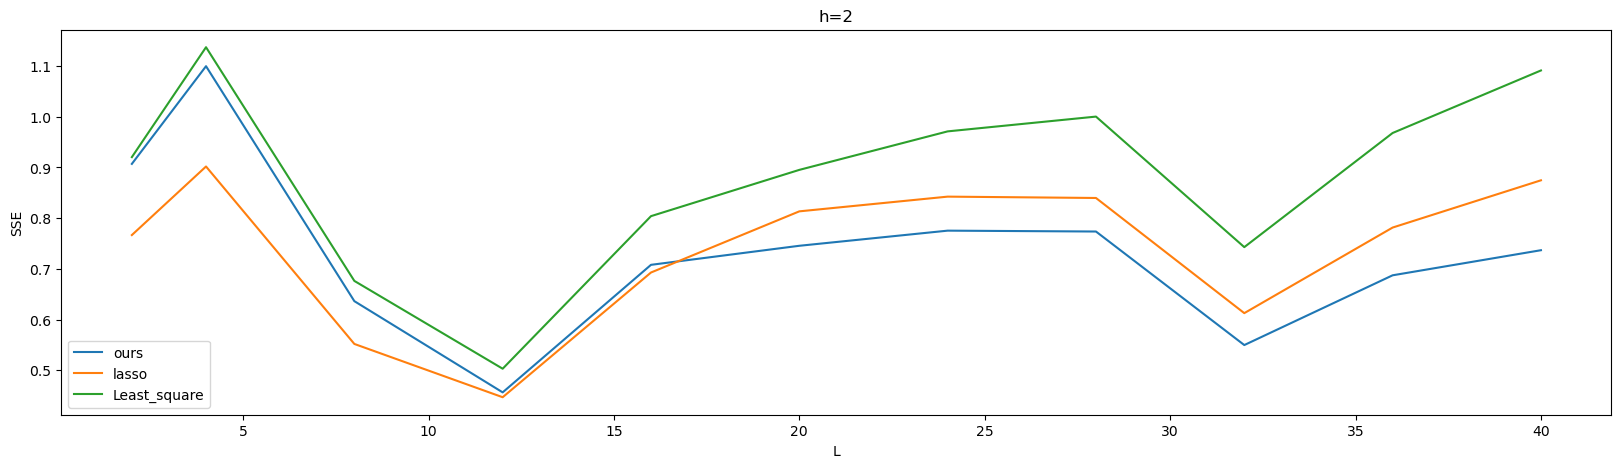

In [11]:
plot_graphs(model_dic,result,h_list,L_list)